In [2]:
import json
import numpy as np 
from collections import defaultdict 

In [3]:
def read_file(path):
    data_by_src = defaultdict(list)
    with open(path, "r") as f1:
        for line in f1:
            line = json.loads(line)
            # trim off last token (EOS)
            line['logit_at_label'] = np.array(line['logit_at_label'][0:-1])
            data_by_src[line['natural']].append(line)

    # for src, list_ in data_by_src.items():
        # assert(len(list_) == 2)

    return data_by_src


In [4]:
data_for_df = []

for model in ["codegen-350M", "codegen-2B", "codegen-6B", "codegen-16B"]:
    for t in ['pp', 'scope', 'revscope', 'bound', 'conj']:
        
        path = f"/brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/{model}/{t}_fol/outputs/test_eval.logits"
        print(f"reading {path}")
        try:
            data_by_src = read_file(path)
        except FileNotFoundError:
            print(f"file not found: {path}")
            continue

        for src, lines in data_by_src.items():
            p_lf0, p_lf1 = None, None
            min_lf0, min_lf1 = None, None
            for line in lines:
                template_idx = str(line['template_idx'])
                total_prob = np.exp(np.sum(np.log(line['logit_at_label'])))

                min_logit_at_label = np.min(line['logit_at_label']) 
                if template_idx == '0':
                    min_lf0 = min_logit_at_label
                    p_lf0 = total_prob
                else:
                    min_lf1 = min_logit_at_label
                    p_lf1 = total_prob

            # turn into a proper probability by normalizing 
            norm_min_p_lf0 = min_lf0 / (min_lf0 + min_lf1)
            norm_total_p_lf0 = p_lf0 / (p_lf0 + p_lf1)

            data_for_df.append({"model": model, "amb_type": t,  "type": "norm_min_lf0", "value": norm_min_p_lf0}) 
            data_for_df.append({"model": model, "amb_type": t,  "type": "norm_total_lf0", "value": norm_total_p_lf0}) 


reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/pp_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/scope_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/revscope_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/bound_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-350M/conj_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/pp_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/scope_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/revscope_fol/outputs/test_eval.logits
reading /brtx/602-nvme1/estengel/ambiguous_parsing/model_outputs/codegen-2B/bound_fol/outputs/test_eval

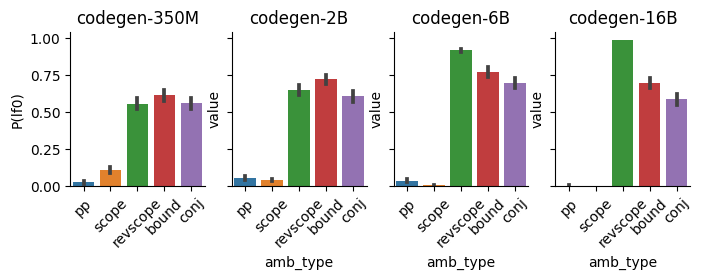

In [5]:
import seaborn as sns
from matplotlib import pyplot as plt 
import pandas as pd

df = pd.DataFrame(data_for_df)

prob_df = df[df['type'] == "norm_total_lf0"]

fig, ax = plt.subplots(1, 4, figsize=(8,2), sharex=True, sharey=True)

for midx, model in enumerate(["codegen-350M", "codegen-2B", "codegen-6B", "codegen-16B"]):
    ax[midx].set_title(model)
    model_df = df[df['model'] == model]  
    sns.barplot(data = model_df, x = "amb_type", y = "value", ax=ax[midx])
    # rotate xticks 45 degrees
    for item in ax[midx].get_xticklabels():
        item.set_rotation(45)

ax[0].set_ylabel("P(lf0)")
ax[0].set_xlabel("")
sns.despine()


/tmp/ipykernel_14818/1004807575.py:39: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['codegen-350M', 'codegen-2B', 'codegen-6B','codegen-16B'])


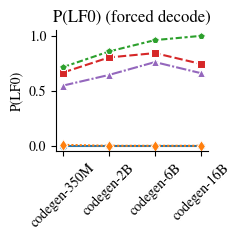

In [50]:
import re 
from colors import colors, markers


plt.rcParams["font.family"] = "Nimbus Roman"

fig, ax = plt.subplots(1, 1, figsize=(2.5,2.5), sharex=True, sharey=True)

def get_size(key):
    lut = {"text-ada-001": "2.5B", "gpt-3.5-turbo": "100B"}
    if key in lut.keys():
        num = lut[key]
    else:
        num = key.split("-")[1]
    if "M" in num:
        num = float(re.sub("M", "", num)) / 100
    else:
        num = float(re.sub("B", "", num)) * 10
    return num

prob_df['model_key'] = prob_df['model'].apply(lambda x: get_size(x))
prob_df = prob_df.sort_values(by=['model_key'])
# convert to str 
prob_df['model_key'] = prob_df['model_key'].apply(lambda x: str(x))

sns.lineplot(data=prob_df, 
            x="model_key", 
            y="value",
            hue="amb_type",
            palette=colors,
            style="amb_type",
            markers=markers,
            errorbar=None,
            ax=ax)

for item in ax.get_xticklabels():
    item.set_rotation(45)

ax.set_xticklabels(['codegen-350M', 'codegen-2B', 'codegen-6B','codegen-16B'])
# ax.legend(frameon=False, ncol=2, bbox_to_anchor=(0.2,0.2), columnspacing=0.2, fontsize=)
ax.legend().remove()
ax.set_ylabel("P(LF0)")
ax.set_xlabel("")
ax.set_title("P(LF0) (forced decode)")
sns.despine()

plt.tight_layout()
plt.savefig("/home/estengel/papers/ambiguous-parsing-2023/figures/zero_shot_forced.pdf")